# Understanding Batch normalization and how to handle it in tensorflow 1.13

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

### Define a toy example. 
Let us $x$ defined as our input variable, defined as a random variable with normal distribution with mean -1 and standard deviation 2, 
$$x\sim~\mathcal{N}(\mu=-3,\sigma=2).$$
We denote $y$ as the output or target variable and which we define affine to $x$, e.g.,
$$y \stackrel{def}{=} \frac{x+11}{4}.$$
Therefore, $y\sim\mathcal{N}(\mu=2,\sigma=1/2)$.

In [2]:
x = np.random.normal(-3,2,1000)
y = (x+11)/4

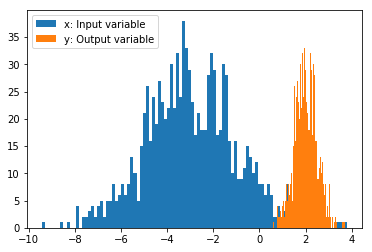

In [3]:
_ = plt.hist(x,100)
_ = plt.hist(y,100)
_ = plt.legend(['x: Input variable','y: Output variable'])

Now let us define a simple network that learn the transformation $f: f(x)=y$.
The network is going to be very simple, first a normalization step (e.g. batch normalization) and then a simple neuron that performs an the affine transformation. 

#### Define the network with diferent normalization strategies. 

In [5]:
import tensorflow.keras.layers as layers_k
import tensorflow.layers as layers_tf
from tensorflow.keras.models import Model

def instance_norm(input_tensor):
    """
    Layer that performs instance normalization. Axes select over which set of axes the 
    mean and standard deviation is computed. For example if we have a tensor with size
    NxHxWxC (N samples, HxW statial resolution, C channels/features), axes=[1,2] will
    normalize it instance using it's mean and std, e.g., mu[k,1,1,C] = mean(tensor[k,:,:,C]),
    if axes=[0,1,2] the normalization performed is equal to the standard batchnorm:
    mu[1,1,1,C] = mean(tensor[:,:,:,C]). 
    --------
    example:
    output_tensor = instance_norm(input_tensor, axes=[1,2])
    """   
    
    # Implementation parameters.
    epsilon = 1e-5  # (regularization) to avoid zero division
    axes = [0,1]  # Select the axes to normalize [1,2] instance, [0,1,2] batch norm
    
    # Normalize the tensor
    mean, variance = tf.nn.moments(input_tensor, axes=axes, keep_dims=True)
    inv = tf.rsqrt(variance + epsilon)
    normalized = (input_tensor-mean)*inv
    return normalized


def l2_normalization(x):
    return tf.math.l2_normalize(x, axis=1)
    
    
def compute_error(y,y_pred):
    return np.mean(np.square(y - y_pred))


In [6]:
def networkA(train_bn=True):  # Using tf batch_normalization
    in_x = layers_k.Input(shape=(1,))
    x = layers_tf.batch_normalization(inputs=in_x, training=train_bn, scale=False, center=False)
    y = layers_k.Dense(1)(x)
    model = Model(inputs=in_x, outputs=y)
    return model

def networkB():  # Using keras batch_normalization
    in_x = layers_k.Input(shape=(1,))
    x = layers_k.BatchNormalization(scale=False, center=False)(in_x)
    y = layers_k.Dense(1)(x)
    model = Model(inputs=in_x, outputs=y)
    return model

def networkC():  # Using custom normalization function 
    in_x = layers_k.Input(shape=(1,))
    x = layers_k.Lambda(instance_norm, name='norm_layer')(in_x)  # <-- we will normalize across the batch 
    y = layers_k.Dense(1)(x)
    model = Model(inputs=in_x, outputs=y)
    return model

def networkD():  # No normalization
    in_x = layers_k.Input(shape=(1,))
    y = layers_k.Dense(1)(in_x)
    model = Model(inputs=in_x, outputs=y)
    return model    


#### Initialize the network

In [7]:
network_used = 'C'
if network_used == 'A':
    model = networkA()
if network_used == 'B':
    model = networkB()
if network_used == 'C':
    model = networkC()
if network_used == 'D': 
    model = networkD()


# Set Network loss and optimizer
from tensorflow.keras import optimizers
sgd = optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd, loss='mean_squared_error')
model.summary()

# We also create an auxiliary model to evaluate the output of the normalization layer.
aux_model = Model(inputs=model.input, outputs=model.layers[1].output)
# aux_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
norm_layer (Lambda)          (None, 1)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


Observe that the network has 4 parameters. Two that are non-trainable (the moving mean and moving variance of bn) and two trainable (the weight and bias of the dense layer). 

In [8]:
import os
tensorboard_dir = '../../tmp/draft_log/' + network_used  # Create a folder where training info is saved
os.makedirs(tensorboard_dir, exist_ok=True)

# Define the callbacks
from tensorflow.keras.callbacks import TensorBoard
callbacks = [TensorBoard(log_dir=tensorboard_dir,
                         histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         update_freq='epoch')]
model.fit(x,y,
          batch_size=20,
          epochs=10,
          validation_data=(x,y),
          callbacks=callbacks)

Train on 1000 samples, validate on 1000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1000/1000 [==============================] - 0s 309us/sample - loss: 1.8083 - val_loss: 0.5590
Epoch 2/10
1000/1000 [==============================] - 0s 139us/sample - loss: 0.2511 - val_loss: 0.0879
Epoch 3/10
1000/1000 [==============================] - 0s 163us/sample - loss: 0.0559 - val_loss: 0.0292
Epoch 4/10
1000/1000 [==============================] - 0s 162us/sample - loss: 0.0208 - val_loss: 0.0222
Epoch 5/10
1000/1000 [==============================] - 0s 144us/sample - loss: 0.0166 - val_loss: 0.0176
Epoch 6/10
1000/1000 [==============================] - 0s 140us/sample - loss: 0.0159 - val_loss: 0.0204
Epoch 7/10
1000/1000 [==============================] - 0s 147us/sample - loss: 0.0210 - val_loss: 0.0183
Epoch 8/10
1000/1000 [==============================] - 0s 138us/sample - loss: 0.0165 - val_loss: 0.0149
Epoch 9/10
1000/1000 [==============================] - 

### Explore what the model learned.

In [9]:
y_pred = model.predict(x)
out_norm = aux_model.predict(x)

print('Error over training data: {:3.2f}'.format(compute_error(y,y_pred)))



Error over training data: 0.47


In [10]:
model.layers[-1].get_weights()

[array([[0.47601262]], dtype=float32), array([2.005794], dtype=float32)]

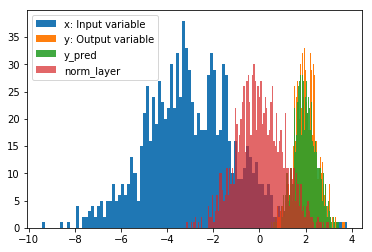

In [11]:
# Display the histograms of the output and the intermediate tensor. 
_ = plt.hist(x,100, alpha=1)
_ = plt.hist(y,100, alpha=1)
_ = plt.hist(y_pred,100, alpha=.9)
_ = plt.hist(out_norm,100, alpha=.7)

_ = plt.legend(['x: Input variable','y: Output variable', 'y_pred', 'norm_layer'])

#### Explore the coeficients learned:

In [12]:
print(model.layers[-1].get_weights())

[array([[0.47601262]], dtype=float32), array([2.005794], dtype=float32)]


Remember that as $x\sim~\mathcal{N}(\mu=-3,\sigma=2)$ and $y \stackrel{def}{=} \frac{x+11}{4}~\mathcal{N}(\mu=2,\sigma=1/2)$, without normalization the affine transformation of the last layer must have coeficients $\omega_i = 1/4 = 0.25$ and $b_i = 11/4=2.75$. 

If we use normalization, as the intermediate layer approximates a $\mathcal{N}(\mu=0,\sigma=0)$, and therefore the coeficients of the last layer should be the ones of the final distribution, i.e., 
$\omega_i = 2$ and $b_i = 1/2$.

### Interesting experiment: What happend when the input data x has a diferent distribution? (Compare network A and B).

For example, we may have another pair $(x,y)$ where $x\sim\mathcal{N}(\mu=1,\sigma=.1)$ holding the same analytical transformation with $y$, i.e., $y = (x+11)/4 \sim\mathcal{N}(\mu=3,\sigma=1/40)$

Error over training data was: 0.47
The error on this data with a different dist. is:1.21


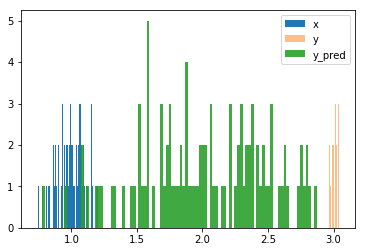

In [13]:
x_test = np.random.normal(1,.1,100)
y_test = (x_test+11)/4 
y_pred_t = model.predict(x_test)

print('Error over training data was: {:3.2f}'.format(compute_error(y,y_pred)))
print('The error on this data with a different dist. is:{:3.2f}'.format(compute_error(y_test,y_pred_t)))

_ = plt.hist(x_test,100, alpha=1)
_ = plt.hist(y_test,100, alpha=.5)
_ = plt.hist(y_pred_t,100, alpha=.9)
_ = plt.legend(['x','y', 'y_pred'])


#### Diferent types of normalization

![Title of the figure](figs/batch_normalization.png)

## Summary: how I will implement my own normalization layer. 

Implemented BachNorm layers do -at least- two things. (1) They normalize the data that is going through them (which is critical for stable training). (2) They add scale and offset parameters to fit the normalized distributions to the optimal range. 

The second task has nothing to do with the normalization, it is simple more paramaters that the network should learn. So, the first thing I want to do is have those learned parameters explicitly separated from the normalization tasks. I found that is trivial to implement this depthwhise normalization using a Depthwise2D convolution with 1 kernel. Is only one scalar kernel and a bias per-channel is used, what we are doing is exacly what renormalization does, each image I_i of size HxW (by image I mean one channel with the activation map) of the batch is going to be adjusted by out = w * I_i + b.

The most important role of batchnorm layers is the normalization. There are two broad ways of thinking this normalization strategies. One way of thinking about it is to see them as a regularization step that is performed during training to make convergence faster. Once all the parameters are set, we need to remember the transformation (normalization) applied and apply the exact same operations when we predict new data. This is the standard behaviour and is what the layer that comes by default with keras does. 

A different mindset, is to think of this normalization steps as regularization and something that is always performed. This means that across the network, the feature representation we obtain is projected into an hyperphere and this projected features are then used for learning in the following portions of the network. If we think about normalization this way, we don't want to kinds of behaviours (during training and testing), we just want a layer that normalize the data that goes through it. In this case, no parameters needs to be learned and the behaviour of the layer is transparent. The implementation in tensorflow.layers.batch_normalization can be tunned to do this, by enforcing training=true (and using that flag even when we call the network for prediction). 

The main reason I am implementing the normalization layer myself is because I want to build a network that contains other smaller networks that can be trained separatelly and at different moments. Therefore I may want a portion of the network to behave as if it were predicting only while other portions of the network are being tunned. I found complicated to do this with the existing implementations as most batchnorm layers change their behaviour depending if we are calling "fit" or "predict". A way to check this kind of problems is to feed the same data for training and validation and see what happens (you may notice that the performance is different over the same data). 

Additionally, I think having the normalization and the parameters that we learn completelly separated will prevent additional bugs when training subnetworks, writing weight, reading etc. Handling the moving mean and moving variance can lead to some bugs when sophisticated newtorks are build. 

### Defining and testing my own implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
import tensorflow.keras.layers as layers_k
import tensorflow.layers as layers_tf
from tensorflow.keras.models import Model

def instance_norm(input_tensor):
    """
    Layer that performs instance normalization. Axes select over which set of axes the 
    mean and standard deviation is computed. For example if we have a tensor with size
    NxHxWxC (N samples, HxW statial resolution, C channels/features), axes=[1,2] will
    normalize it instance using it's mean and std, e.g., mu[k,1,1,C] = mean(tensor[k,:,:,C]),
    if axes=[0,1,2] the normalization performed is equal to the standard batchnorm:
    mu[1,1,1,C] = mean(tensor[:,:,:,C]). 
    --------
    example:
    output_tensor = instance_norm(input_tensor)
    """   
    
    # Implementation parameters.
    epsilon = 1e-5  # (regularization) to avoid zero division
    axes = [1,2]  # Select the axes to normalize [1,2] instance, [0,1,2] batch norm
    
    # Normalize the tensor
    mean, variance = tf.nn.moments(input_tensor, axes=axes, keep_dims=True)
    inv = tf.rsqrt(variance + epsilon)
    normalized = (input_tensor-mean)*inv
    return normalized


def instance_norm_and_scale(input_tensor, name='0'):
    x = layers_k.Lambda(instance_norm, name=name+'_norm')(input_tensor)  # <-- we will normalize across the batch 
    x = layers_k.DepthwiseConv2D(1, depth_multiplier=1, 
                                 use_bias=True,
                                 name=name+'_scale')(x)  # <-- rescale each feat.
    return x

Define a toy network to test normalization and rescaling block

In [3]:
def network():  # Testing our normalization and rescaling approach.
    in_x = layers_k.Input(shape=(128,128,3))
    y = instance_norm_and_scale(in_x, 'norm0')
    model = Model(inputs=in_x, outputs=y)
    return model


In [4]:
model = network()
    
# Set Network loss and optimizer
from tensorflow.keras import optimizers
sgd = optimizers.SGD(lr=0.05)
model.compile(optimizer=sgd, loss='mean_squared_error')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
norm0_norm (Lambda)          (None, 128, 128, 3)       0         
_________________________________________________________________
norm0_scale (DepthwiseConv2D (None, 128, 128, 3)       6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


To test the implemented block, we grab an image with different mean and std per channel, and we fit the network to return the same image. As the first layer normaliza each channel of the instace, the second layer should rescale it to its original values.

(-0.5, 127.5, 127.5, -0.5)

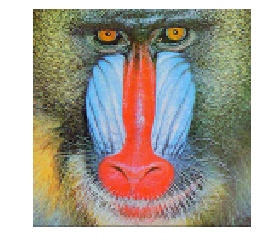

In [5]:
I = plt.imread('figs/baboon.png')
plt.imshow(I); plt.axis('off')

In [6]:
I[:,:,0] -= 1
I[:,:,2] += 1
print(np.mean(I,axis=(0,1)))
print(np.std(I,axis=(0,1)))

[-0.45879206  0.50496656  1.4470168 ]
[0.20314406 0.16247594 0.22320616]


In [7]:
x = I
x = np.expand_dims(x,0)  # image to batch
noise = np.random.normal(loc=0,scale=.2,size=(100,128,128,3))
x = x + noise
y = x  # set output and input as the same

(-0.5, 127.5, 127.5, -0.5)

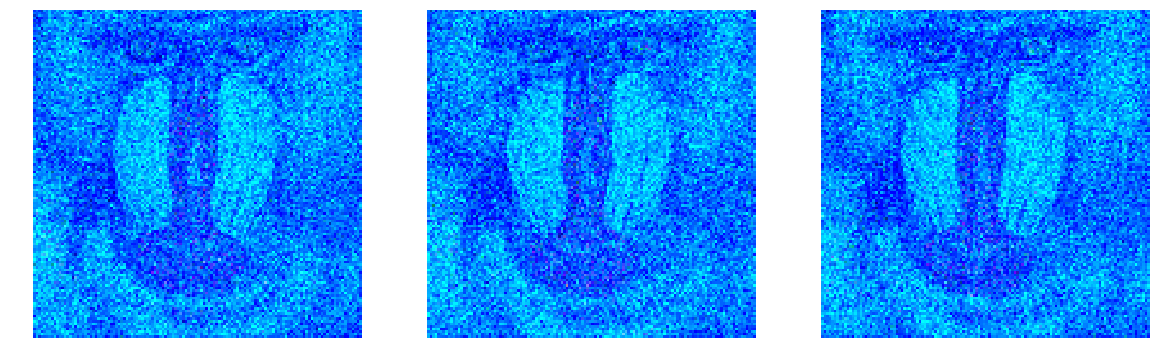

In [8]:
plt.figure(figsize=[20,60])
plt.subplot(131); plt.imshow(x[0,:,:,:].squeeze().clip(0,1)); plt.axis('off')
plt.subplot(132); plt.imshow(x[4,:,:,:].squeeze().clip(0,1)); plt.axis('off')
plt.subplot(133); plt.imshow(x[40,:,:,:].squeeze().clip(0,1)); plt.axis('off')

In [13]:
import os
tensorboard_dir = '../../tmp/draft_log/' + 'normalization_test1'  # Create a folder where training info is saved
os.makedirs(tensorboard_dir, exist_ok=True)

# Define the callbacks
from tensorflow.keras.callbacks import TensorBoard
callbacks = [TensorBoard(log_dir=tensorboard_dir,
                         histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         update_freq='epoch')]
model.fit(x,y,
          batch_size=25,
          epochs=35,
          validation_data=(x,y),
          callbacks=callbacks)

Train on 100 samples, validate on 100 samples
Epoch 1/35
100/100 [==============================] - 2s 16ms/sample - loss: 0.0217 - val_loss: 0.0183
Epoch 2/35
100/100 [==============================] - 1s 12ms/sample - loss: 0.0165 - val_loss: 0.0139
Epoch 3/35
100/100 [==============================] - 1s 12ms/sample - loss: 0.0126 - val_loss: 0.0106
Epoch 4/35
100/100 [==============================] - 1s 13ms/sample - loss: 0.0096 - val_loss: 0.0081
Epoch 5/35
100/100 [==============================] - 1s 12ms/sample - loss: 0.0073 - val_loss: 0.0062
Epoch 6/35
100/100 [==============================] - 1s 15ms/sample - loss: 0.0056 - val_loss: 0.0047
Epoch 7/35
100/100 [==============================] - 1s 13ms/sample - loss: 0.0043 - val_loss: 0.0036
Epoch 8/35
100/100 [==============================] - 1s 12ms/sample - loss: 0.0033 - val_loss: 0.0027
Epoch 9/35
100/100 [==============================] - 1s 13ms/sample - loss: 0.0025 - val_loss: 0.0021
Epoch 10/35
100/100 [======

If the normalization and rescaling is working, the kernel and bias learned by the rescaling should be equal to the mean and standard deviation of the input (as they have to invert the normalization process). Check that the value of the kernels of the layer match the mean and std of the input:

In [22]:
print('Network offset and input mean')
print(model.layers[2].get_weights()[1])
print(x.mean(axis=(0,1,2)))
print('Network scale and input std')
print(model.layers[2].get_weights()[0].squeeze())
print(x.std(axis=(0,1,2)))

Network offset and input mean
[-0.4584341  0.5045529  1.4453475]
[-0.45895347  0.50512675  1.44699043]
Network scale and input std
[0.28483653 0.2586039  0.2988267 ]
[0.28520983 0.25766616 0.29987513]


Now let us do a last sanity check which is checking that the output of the instance normalization layer actually normalize each instance.

In [23]:
# We also create an auxiliary model to evaluate the output of the normalization layer.
aux_model = Model(inputs=model.input, outputs=model.layers[1].output)
# aux_model.summary()


[ 2.1668093e-06 -1.2507880e-06  1.6360509e-05]
[0.99994004 0.99992466 0.9999448 ]
[-1.4343314e-06  3.4011464e-08  3.2129537e-06]
[0.99993736 0.99992496 0.9999453 ]
[ 4.2726533e-06  3.5874109e-07 -2.6416419e-06]
[0.99994016 0.999923   0.9999453 ]
[-4.8697984e-08 -4.7222602e-06  8.2512643e-06]
[0.99993974 0.9999204  0.9999458 ]
[1.5668702e-06 4.4623084e-06 1.1302078e-05]
[0.9999378  0.9999243  0.99994653]


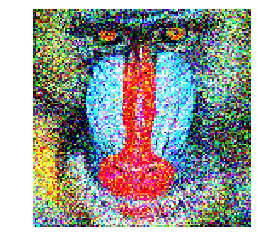

In [34]:
y = aux_model.predict(x[:5,:,:,:])  # Pass throught the normalization layer some images in the batch 

for i in range(y.shape[0]):
    yy = y[i,:,:,:].squeeze()
    plt.imshow(np.clip((yy+1)/2,0,1)); plt.axis('off')
    print(yy.mean(axis=(0,1)))
    print(yy.std(axis=(0,1)))